# Tutorial 0: Data Preparation
Welcome to the Cell2Sentence (C2S) tutorial series! In this first tutorial, we will guide you through the process of preparing and preprocessing a single-cell RNA sequencing dataset for use with C2S. This step is important because the processed data produced in this notebook will be used in all subsequent tutorials, so make sure to complete this notebook first before moving on to the others if you are using the example data.

If you are processing your own dataset, keep a few things in mind:
1. This notebook assumes you are starting from a single-cell dataset with raw transcript counts. You can follow these steps to preprocess your dataset for use with C2S.
2. If you are starting from pre-normalized data, keep in mind that C2S normalization consists of the standard filtering & count normalization steps outlined by Scanpy, with the exception that the log1p transformation is applied with base 10. For best results with the inverse reconstruction (going from cell sentences back to expression, shown in tutorial 1), make sure to use base-10 normalized data as shown in this tutorial.


We will be working with a subset of data from the Immune System tissue dataset by Domínguez Conde et al. This dataset provides an excellent foundation for demonstrating how to convert raw single-cell data into a format that can be used with C2S models.

- **Dataset Information**:
  - Source: Immune System tissue dataset from Domínguez Conde et al. (2022)
  - Link: [Science Article](https://www.science.org/doi/full/10.1126/science.abl5197)
  - Citation: Domínguez Conde, C., et al. "Cross-tissue immune cell analysis reveals tissue-specific features in humans." Science 376.6594 (2022): eabl5197.
- Subset Used: We use data from two donors (A29 and A31), totaling 29,773 cells. This subset is chosen to keep the tutorial data manageable.

First, we will import the necessary libraries. These include general-purpose Python libraries, as well as specialized libraries for single-cell RNA sequencing data analysis.

In [1]:
# Python built-in libraries
import os
import random
from collections import Counter

# Third-party libraries
import numpy as np

# Single-cell libraries
import anndata
import scanpy as sc

This next cell will set a random seed. This seed will control any random operations that occur in the code, ensuring that they produce the same output each time you run the notebook.

In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Load Data

Next, we will load the dataset. The dataset is stored in the AnnData format, which is commonly used for single-cell RNA sequencing data (scRNAseq). This format efficiently handles large datasets and provides useful functions for analysis.

We will use a dataset containing two donor samples from the Domínguez Conde et al. study. Here is a Google Drive link where you can download the data:
- https://drive.google.com/file/d/1k5OoDVzk7CusHWEUZO7ENPbMZYjx-p0l/view?usp=sharing

Make sure you have downloaded this file (H5AD format) from our Google Drive link and set the correct file path before running the following code.

In [3]:
DATA_PATH = "/home/sr2464/palmer_scratch/C2S_Files_Syed/Cell2Sentence_Datasets/dominguez_conde_immune_tissue_two_donors.h5ad"

In [4]:
adata = anndata.read_h5ad(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 29773 × 36503
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'assay', 'sex'
    var: 'gene_name', 'ensembl_id'

The data contains multiple metadata annotations, such as cell type and tissue information. We will look through the dataset attributes quickly:

In [5]:
adata.obs.head()

,cell_type,tissue,batch_condition,organism,assay,sex
Pan_T7935490_AAACCTGCAAATTGCC,CD4-positive helper T cell,ileum,A29,Homo sapiens,10x 5' v1,female
Pan_T7935490_AAACGGGCATCTGGTA,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,10x 5' v1,female
Pan_T7935490_AAACGGGTCTTGCATT,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,10x 5' v1,female
Pan_T7935490_AAAGCAATCATCGCTC,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,10x 5' v1,female
Pan_T7935490_AAAGTAGCAGTCACTA,gamma-delta T cell,ileum,A29,Homo sapiens,10x 5' v1,female


In [6]:
Counter(adata.obs["batch_condition"])  # two donor samples

Counter({'A29': 17327, 'A31': 12446})

We can see that we have cell type, tissue, and organism annotations in this dataset. Also, we can see the cell counts from both donors in our immune tissue dataset.

In [7]:
Counter(adata.obs["tissue"])

Counter({'ileum': 379,
         'lung': 4458,
         'thoracic lymph node': 7573,
         'mesenteric lymph node': 5209,
         'bone marrow': 1773,
         'skeletal muscle tissue': 18,
         'liver': 2716,
         'spleen': 5794,
         'omentum': 30,
         'caecum': 339,
         'thymus': 354,
         'duodenum': 735,
         'transverse colon': 262,
         'sigmoid colon': 133})

In [8]:
Counter(adata.obs["cell_type"])

Counter({'CD4-positive helper T cell': 537,
         'CD8-positive, alpha-beta memory T cell': 579,
         'gamma-delta T cell': 481,
         'macrophage': 2404,
         'alpha-beta T cell': 486,
         'CD8-positive, alpha-beta memory T cell, CD45RO-positive': 1369,
         'lymphocyte': 424,
         'memory B cell': 3584,
         'regulatory T cell': 1582,
         'naive B cell': 2223,
         'plasma cell': 715,
         'effector memory CD4-positive, alpha-beta T cell': 1249,
         'effector memory CD8-positive, alpha-beta T cell, terminally differentiated': 1181,
         'conventional dendritic cell': 251,
         'T follicular helper cell': 1430,
         'animal cell': 303,
         'group 3 innate lymphoid cell': 116,
         'naive thymus-derived CD4-positive, alpha-beta T cell': 4262,
         'alveolar macrophage': 1180,
         'CD16-positive, CD56-dim natural killer cell, human': 498,
         'classical monocyte': 1003,
         'mast cell': 88,
        

There are diverse immune cell types and subtypes within this data, which makes for interesting prediction and generation tasks later on!

In [9]:
adata.var.head()

,gene_name,ensembl_id
MIR1302-2HG,MIR1302-2HG,ENSG00000243485
FAM138A,FAM138A,ENSG00000237613
OR4F5,OR4F5,ENSG00000186092
RP11-34P13,RP11-34P13,ENSG00000238009
RP11-34P13-1,RP11-34P13,ENSG00000239945


We also have both gene names as well as ensembl IDs in our data. The gene names are important, since they will make up the cell sentences we create later on, so we will keep gene names as the adata.var_names in our AnnData object. The var_names will be used to create the cell sentences by the C2S code base functions later on.

In [10]:
adata.X

<29773x36503 sparse matrix of type '<class 'numpy.float32'>'
	with 48394900 stored elements in Compressed Sparse Row format>

In [11]:
adata.X.data[:10]  # we can see from the count values that we have raw counts

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 6.], dtype=float32)

Looking at the transcript counts, we can see that we are starting from raw counts.

## Data preprocessing
Now we will preprocess and normalize the data, following standard processing pipelines (Scanpy reference tutorial: https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html).

Cell2Sentence only deviates from the standard preprocessing and normalization pipeline in that the log transformation is done with a base of 10 rather than natural logarithm. We start with simple filtering steps:

In [12]:
adata

AnnData object with n_obs × n_vars = 29773 × 36503
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'assay', 'sex'
    var: 'gene_name', 'ensembl_id'

In [13]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [14]:
adata

AnnData object with n_obs × n_vars = 29773 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'assay', 'sex', 'n_genes'
    var: 'gene_name', 'ensembl_id', 'n_cells'

We now can annotate mitochondrial gene counts in our cells, for additional potential filtering steps:

In [15]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

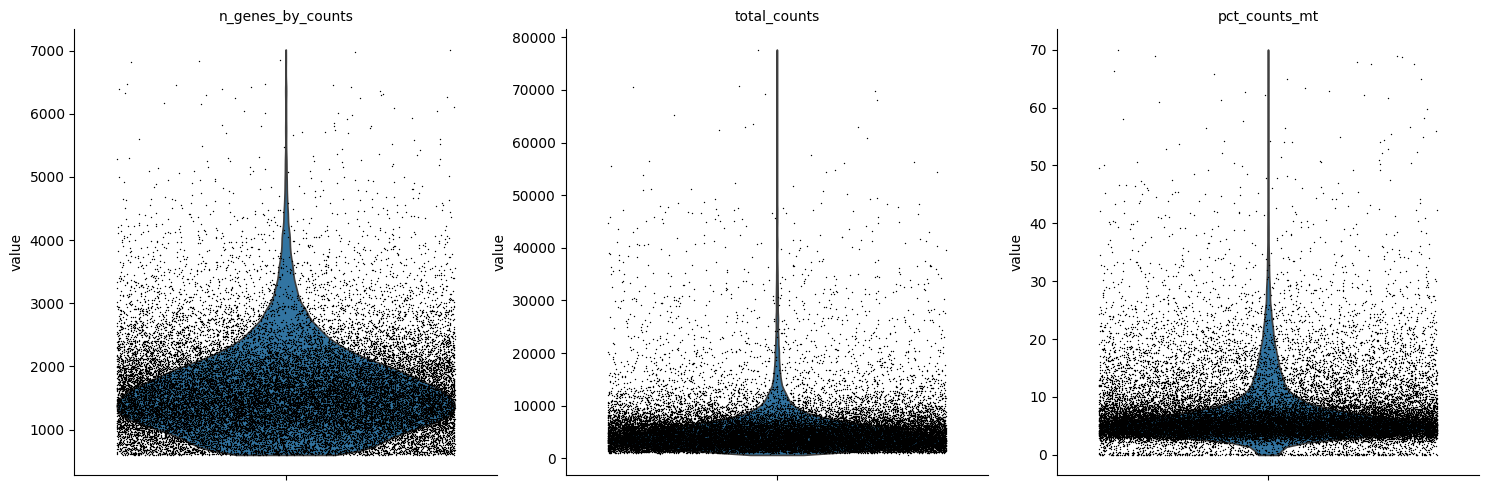

In [16]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

We have the option here to filter out cells based on quality-control metrics based on mitochondrial genes, but following the guidance
of the Scanpy tutorial (https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html#quality-control), we will stick with
a lenient filtering based only on min_cells and min_genes in the previous cell. This filtering step can be revisited if desired to filter
out more cells based on QC metrics.

In [17]:
# adata = adata[adata.obs.n_genes_by_counts < 6000, :]
# adata = adata[adata.obs.pct_counts_mt < 50, :].copy()

# Normalization

Now, we normalize our data. We follow the typical count normalization and log1p transformation steps to normalize single-cell datasets for use with C2S. The only difference is that we perform the log1p transformation with base 10, rather than the default natural logarithm. We empirically found this base 10 log1p transformation to work well for inverse reconstruction of expression using a linear model, which will be shown in tutorial notebook 1.

In [18]:
# Count normalization
sc.pp.normalize_total(adata)
# Lop1p transformation with base 10 - base 10 is important for C2S transformation!
sc.pp.log1p(adata, base=10)  

In [19]:
adata.X.max()

3.408124

With a base 10 log transformation, the largest value in our count matrix is now ~3.4, which is expected for a base-10 log transformation.

# Visualization

Now let's process our adata object for UMAP visualization of our dataset. We will run PCA, Scanpy's neighbors algorithm, and then the UMAP algorithm implemented by Scanpy.

In [20]:
sc.tl.pca(adata)

In [21]:
sc.pp.neighbors(adata)

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
sc.tl.umap(adata)

We can visualize the UMAPs of the processed data colored by donor, cell type, and tissue metadata

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


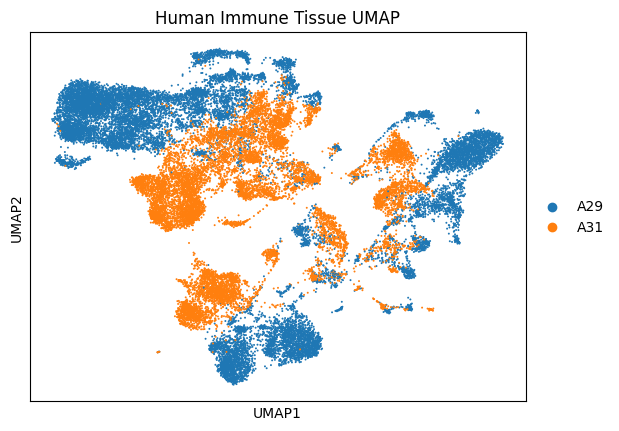

In [23]:
sc.pl.umap(
    adata,
    color="batch_condition",
    size=8,
    title="Human Immune Tissue UMAP",
)

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


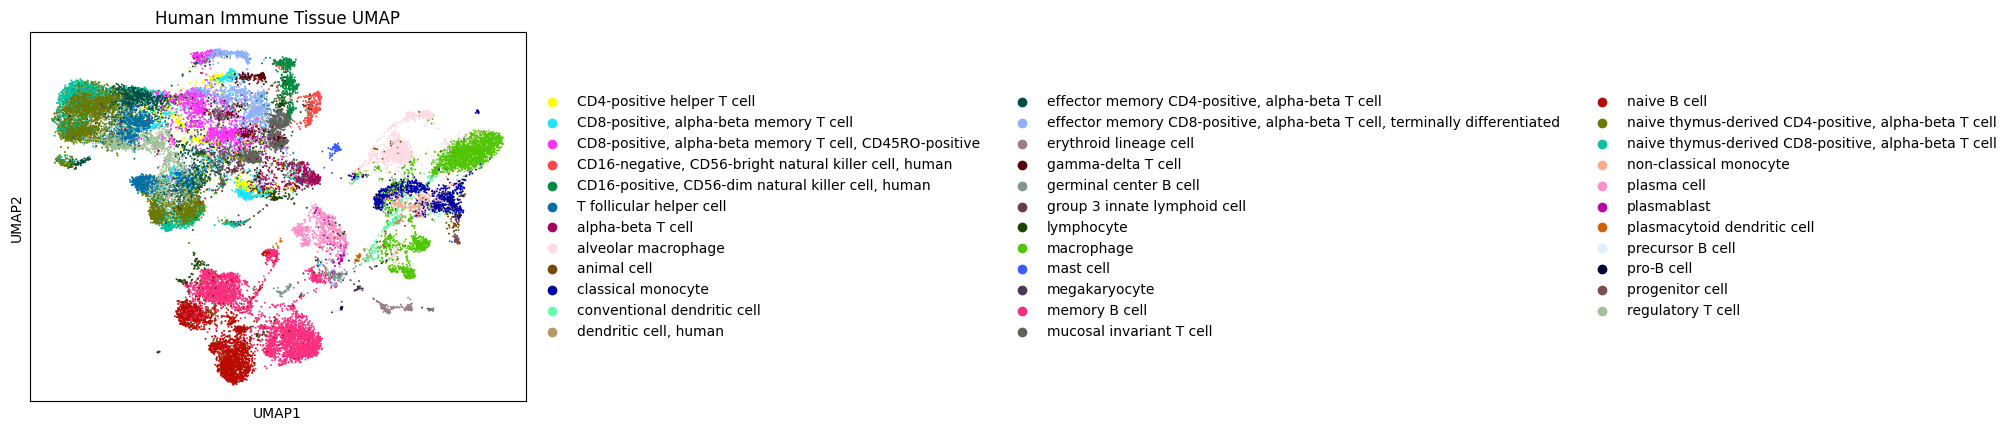

In [24]:
sc.pl.umap(
    adata,
    color="cell_type",
    size=8,
    title="Human Immune Tissue UMAP",
)

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


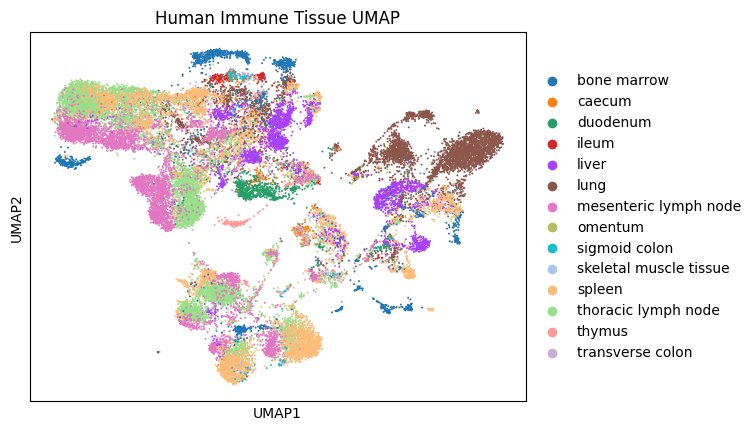

In [25]:
sc.pl.umap(
    adata,
    color="tissue",
    size=8,
    title="Human Immune Tissue UMAP",
)

Finally, we will save dataset to disk. This processed dataset will be used for all further tutorials, so make sure to keep this filepath handy for future tutorials.

In [26]:
SAVE_PATH = "/home/sr2464/palmer_scratch/C2S_Files_Syed/Cell2Sentence_Datasets/dominguez_conde_immune_tissue_two_donors_preprocessed_tutorial_0.h5ad"

In [27]:
adata.write_h5ad(SAVE_PATH)